In [3]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
# Home Credit Default Risk - Loan Default Prediction Model
# A step-by-step approach for beginners

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score
import os
import gc  # For garbage collection to manage memory
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('ggplot')
sns.set_style('whitegrid')

# Define the base directory where all files are located
BASE_DIR = '/Users/braidosan/Downloads/home-credit-default-risk/'

In [2]:
# Load the main application data files
app_train = pd.read_csv(os.path.join(BASE_DIR, 'application_train.csv'))
app_test = pd.read_csv(os.path.join(BASE_DIR, 'application_test.csv'))

# Check the shape of the datasets
print(f"Training data shape: {app_train.shape}")
print(f"Testing data shape: {app_test.shape}")

# Check the target variable distribution
print("\nTarget variable distribution:")
print(app_train['TARGET'].value_counts())
print(app_train['TARGET'].value_counts() / len(app_train))

# Display basic information about the training data
print("\nBasic information about the training data:")
print(app_train.info())

# Display basic statistics
print("\nBasic statistics for numeric columns:")
print(app_train.describe())

# Check for missing values in each column
print("\nMissing values in each column:")
missing_values = app_train.isnull().sum()
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)
print(missing_values.head(10))  # Print top 10 columns with missing values

Training data shape: (307511, 122)
Testing data shape: (48744, 121)

Target variable distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64
TARGET
0    0.919271
1    0.080729
Name: count, dtype: float64

Basic information about the training data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(41), object(16)
memory usage: 286.2+ MB
None

Basic statistics for numeric columns:
          SK_ID_CURR         TARGET   CNT_CHILDREN  AMT_INCOME_TOTAL  \
count  307511.000000  307511.000000  307511.000000      3.075110e+05   
mean   278180.518577       0.080729       0.417052      1.687979e+05   
std    102790.175348       0.272419       0.722121      2.371231e+05   
min    100002.000000       0.000000       0.000000      2.565000e+04   
25%    189145.500000       0.000000       0.000000      1.125000e+05   
50%    278202.000000       0.000000       0.000000   

In [3]:
def preprocess_data(df, test_df=None, encoding=True, scaling=True):
    """
    Preprocess the data for model training
    
    Args:
        df: DataFrame with training data
        test_df: DataFrame with test data (optional)
        encoding: Whether to perform label encoding on categorical variables
        scaling: Whether to scale numeric features
        
    Returns:
        Processed DataFrame(s)
    """
    # Make a copy of the dataframes
    train_df = df.copy()
    
    if test_df is not None:
        test_df = test_df.copy()
        # Combine train and test for preprocessing
        train_len = len(train_df)
        combined_df = pd.concat([train_df.drop('TARGET', axis=1), test_df])
    else:
        combined_df = train_df.drop('TARGET', axis=1)
        train_len = len(combined_df)
    
    # Handle missing values
    # For numerical columns, fill with median
    num_cols = combined_df.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = combined_df.select_dtypes(include=['object']).columns
    
    # Handle infinities and very large values BEFORE imputation
    # Replace infinity values with NaN
    combined_df = combined_df.replace([np.inf, -np.inf], np.nan)
    
    # For each numeric column, clip extreme values to reasonable bounds
    for col in num_cols:
        if combined_df[col].isnull().sum() < len(combined_df):  # If not all values are null
            # Get the non-null values to calculate percentiles
            non_null_values = combined_df[col].dropna()
            if len(non_null_values) > 0:
                q1 = non_null_values.quantile(0.01)
                q3 = non_null_values.quantile(0.99)
                iqr = q3 - q1
                lower_bound = q1 - 3 * iqr
                upper_bound = q3 + 3 * iqr
                # Clip outliers
                combined_df[col] = combined_df[col].clip(lower_bound, upper_bound)
    
    # Now fill missing values
    # Use SimpleImputer for numerical columns
    for col in num_cols:
        # Fill NaN with median
        median_value = combined_df[col].median()
        combined_df[col] = combined_df[col].fillna(median_value)
    
    # Fill categorical missing values with 'Unknown'
    combined_df[cat_cols] = combined_df[cat_cols].fillna('Unknown')
    
    # Encode categorical variables if requested
    if encoding:
        for col in cat_cols:
            # Convert to string to handle any non-string objects
            combined_df[col] = combined_df[col].astype(str)
            # Use LabelEncoder
            le = LabelEncoder()
            combined_df[col] = le.fit_transform(combined_df[col])
    
    # Scale numeric features if requested
    if scaling:
        for col in num_cols:
            # Check for any remaining infinities or NaN values
            if np.isinf(combined_df[col]).any() or combined_df[col].isnull().any():
                # Handle these by filling with median
                combined_df[col] = combined_df[col].replace([np.inf, -np.inf], np.nan)
                combined_df[col] = combined_df[col].fillna(combined_df[col].median())
            
            # Apply standard scaling
            mean_val = combined_df[col].mean()
            std_val = combined_df[col].std()
            if std_val > 0:  # Avoid division by zero
                combined_df[col] = (combined_df[col] - mean_val) / std_val
            else:
                # If std is 0, just center the data
                combined_df[col] = combined_df[col] - mean_val
    
    # Split back into train and test
    if test_df is not None:
        train_processed = combined_df.iloc[:train_len, :]
        test_processed = combined_df.iloc[train_len:, :]
        # Add TARGET back to train
        train_processed['TARGET'] = train_df['TARGET']
        return train_processed, test_processed
    else:
        train_processed = combined_df
        train_processed['TARGET'] = train_df['TARGET']
        return train_processed

# Function to train a simple model and evaluate
def train_and_evaluate(train_df):
    """
    Train a simple LightGBM model and evaluate with cross-validation
    
    Args:
        train_df: Processed training DataFrame
    
    Returns:
        Trained model and CV score
    """
    # Prepare features and target
    X = train_df.drop('TARGET', axis=1)
    y = train_df['TARGET']
    
    # IMPORTANT: Clean feature names to remove special characters
    # LightGBM doesn't support special characters in feature names
    X_clean = X.copy()
    # Create a mapping of old to new column names
    column_mapping = {}
    
    for col in X_clean.columns:
        # Replace any special characters with underscore
        new_col = re.sub(r'[^A-Za-z0-9_]', '_', col)
        # Ensure the column name doesn't start with a number
        if new_col[0].isdigit():
            new_col = 'f_' + new_col
        # Add a suffix to avoid duplicates if needed
        counter = 1
        temp_col = new_col
        while temp_col in column_mapping.values():
            temp_col = f"{new_col}_{counter}"
            counter += 1
        new_col = temp_col
        column_mapping[col] = new_col
    
    # Rename columns
    X_clean.columns = [column_mapping[col] for col in X_clean.columns]
    
    # Split data for validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_clean, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Define the model
    model = lgbm.LGBMClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=32,
        colsample_bytree=0.8,
        subsample=0.8,
        max_depth=8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        min_split_gain=0.01,
        min_child_weight=2,
        random_state=42
    )
    
    # Train the model
    try:
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[lgbm.early_stopping(100)]
        )
    except Exception as e:
        # Fallback to a simpler fit if the above fails
        print(f"Error in model.fit: {e}")
        print("Falling back to simpler fit...")
        model = lgbm.LGBMClassifier(
            n_estimators=500,
            learning_rate=0.05,
            random_state=42
        )
        model.fit(X_train, y_train)
    
    # Predict on validation set
    y_pred = model.predict_proba(X_val)[:, 1]
    
    # Calculate AUC
    auc = roc_auc_score(y_val, y_pred)
    print(f"Validation AUC: {auc}")
    
    # Manual cross-validation to avoid any parameter issues
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = []
    
    for train_idx, val_idx in cv.split(X_clean, y):
        X_cv_train, X_cv_val = X_clean.iloc[train_idx], X_clean.iloc[val_idx]
        y_cv_train, y_cv_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Create a new model for each fold
        cv_model = lgbm.LGBMClassifier(
            n_estimators=500,  # Reduced for speed
            learning_rate=0.05,
            random_state=42
        )
        
        try:
            # Train the model
            cv_model.fit(X_cv_train, y_cv_train)
            
            # Predict and calculate AUC
            cv_pred = cv_model.predict_proba(X_cv_val)[:, 1]
            cv_auc = roc_auc_score(y_cv_val, cv_pred)
            cv_scores.append(cv_auc)
            
            print(f"Fold AUC: {cv_auc:.4f}")
        except Exception as e:
            print(f"Error in CV fold: {e}")
            # If a fold fails, we'll skip it
            continue
    
    if cv_scores:
        # Calculate mean CV score
        cv_mean = np.mean(cv_scores)
        cv_std = np.std(cv_scores)
        print(f"Cross-validation AUC: {cv_mean:.4f} ± {cv_std:.4f}")
    else:
        cv_mean = 0
        print("Cross-validation failed.")
    
    # Save the column mapping for later use with test data
    model.feature_names = list(X_clean.columns)
    model.column_mapping = column_mapping
    
    return model, cv_mean

In [4]:
def make_test_predictions(model, test_df):
    """
    Make predictions on the test set with a trained model
    
    Args:
        model: Trained LightGBM model
        test_df: Test DataFrame
    
    Returns:
        Predictions
    """
    # Get the column mapping from the model
    column_mapping = getattr(model, 'column_mapping', None)
    
    # Prepare test features
    X_test = test_df.copy()
    
    if column_mapping:
        # Rename columns to match what the model was trained on
        X_test_clean = X_test.copy()
        # Only keep columns that are in the mapping
        X_test_clean = X_test_clean[[col for col in X_test_clean.columns if col in column_mapping]]
        # Rename columns
        X_test_clean.columns = [column_mapping[col] for col in X_test_clean.columns]
        # Make sure all columns the model expects are present
        for col in model.feature_names:
            if col not in X_test_clean.columns:
                X_test_clean[col] = 0  # Add missing columns with zeros
        # Reorder columns to match model's expected order
        X_test_clean = X_test_clean[model.feature_names]
        
        # Make predictions
        predictions = model.predict_proba(X_test_clean)[:, 1]
    else:
        # If no column mapping, just use the test data as is
        predictions = model.predict_proba(X_test)[:, 1]
    
    return predictions

In [5]:
# Preprocess the data
train_processed, test_processed = preprocess_data(app_train, app_test)

# Check the shape after preprocessing
print(f"Processed training data shape: {train_processed.shape}")
print(f"Processed test data shape: {test_processed.shape}")

# Train the model
model, cv_score = train_and_evaluate(train_processed)

# Make predictions on the test set
test_predictions = model.predict_proba(test_processed)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'SK_ID_CURR': app_test['SK_ID_CURR'],
    'TARGET': test_predictions
})

submission_path = os.path.join(BASE_DIR, 'submission.csv')
submission.to_csv(submission_path, index=False)
print(f"Submission saved to {submission_path}")

Processed training data shape: (307511, 122)
Processed test data shape: (48744, 121)
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043796 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 11252
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 101
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[430]	valid_0's binary_logloss:

In [6]:
def feature_engineering(df, test_df=None):
    """
    Create new features for the model
    
    Args:
        df: Training DataFrame
        test_df: Test DataFrame (optional)
        
    Returns:
        DataFrames with new features
    """
    # Make copies of the dataframes
    train_df = df.copy()
    
    if test_df is not None:
        test_df = test_df.copy()
        # Combine train and test for preprocessing
        train_len = len(train_df)
        combined_df = pd.concat([train_df.drop('TARGET', axis=1), test_df])
    else:
        combined_df = train_df.drop('TARGET', axis=1)
        train_len = len(combined_df)
    
    # Safe division function to avoid division by zero
    def safe_div(a, b, default=0):
        return np.divide(a, b, out=np.full_like(a, default, dtype=float), where=b!=0)
    
    # Credit to income ratio
    combined_df['CREDIT_TO_INCOME_RATIO'] = safe_div(combined_df['AMT_CREDIT'], combined_df['AMT_INCOME_TOTAL'])
    
    # Annuity to income ratio
    combined_df['ANNUITY_TO_INCOME_RATIO'] = safe_div(combined_df['AMT_ANNUITY'], combined_df['AMT_INCOME_TOTAL'])
    
    # Credit to annuity ratio
    combined_df['CREDIT_TO_ANNUITY_RATIO'] = safe_div(combined_df['AMT_CREDIT'], combined_df['AMT_ANNUITY'])
    
    # Income per family member
    combined_df['INCOME_PER_PERSON'] = safe_div(combined_df['AMT_INCOME_TOTAL'], combined_df['CNT_FAM_MEMBERS'])
    
    # Age in years (negative days converted to positive years)
    combined_df['AGE_YEARS'] = combined_df['DAYS_BIRTH'] / -365
    
    # Employment length in years (negative days converted to positive years)
    combined_df['EMPLOYMENT_YEARS'] = combined_df['DAYS_EMPLOYED'] / -365
    
    # Replace anomalous values in DAYS_EMPLOYED
    combined_df.loc[combined_df['DAYS_EMPLOYED'] == 365243, 'DAYS_EMPLOYED'] = np.nan
    combined_df['DAYS_EMPLOYED_ANOMALY'] = (combined_df['DAYS_EMPLOYED'] == 365243).astype(int)
    
    # Income to credit ratio
    combined_df['INCOME_TO_CREDIT_RATIO'] = safe_div(combined_df['AMT_INCOME_TOTAL'], combined_df['AMT_CREDIT'])
    
    # Flag if income less than credit
    combined_df['INCOME_LESS_THAN_CREDIT'] = (combined_df['AMT_INCOME_TOTAL'] < combined_df['AMT_CREDIT']).astype(int)
    
    # Flag if income less than loan annuity
    combined_df['INCOME_LESS_THAN_ANNUITY'] = (combined_df['AMT_INCOME_TOTAL'] < combined_df['AMT_ANNUITY']).astype(int)
    
    # Polynomial features of external scores
    for col in ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']:
        if col in combined_df.columns:
            combined_df[f'{col}_SQ'] = combined_df[col] ** 2
    
    # Interactions between external scores
    if 'EXT_SOURCE_1' in combined_df.columns and 'EXT_SOURCE_2' in combined_df.columns:
        combined_df['EXT_SOURCE_1_X_EXT_SOURCE_2'] = combined_df['EXT_SOURCE_1'] * combined_df['EXT_SOURCE_2']
    
    if 'EXT_SOURCE_1' in combined_df.columns and 'EXT_SOURCE_3' in combined_df.columns:
        combined_df['EXT_SOURCE_1_X_EXT_SOURCE_3'] = combined_df['EXT_SOURCE_1'] * combined_df['EXT_SOURCE_3']
    
    if 'EXT_SOURCE_2' in combined_df.columns and 'EXT_SOURCE_3' in combined_df.columns:
        combined_df['EXT_SOURCE_2_X_EXT_SOURCE_3'] = combined_df['EXT_SOURCE_2'] * combined_df['EXT_SOURCE_3']
    
    # Replace infinities and NaNs in the new features
    new_cols = set(combined_df.columns) - set(df.columns)
    for col in new_cols:
        if combined_df[col].dtype in ['int64', 'float64']:
            combined_df[col] = combined_df[col].replace([np.inf, -np.inf], np.nan)
            combined_df[col] = combined_df[col].fillna(0)  # Fill with 0 for engineered features
    
    # Split back into train and test
    if test_df is not None:
        train_processed = combined_df.iloc[:train_len, :]
        test_processed = combined_df.iloc[train_len:, :]
        # Add TARGET back to train
        train_processed['TARGET'] = train_df['TARGET']
        return train_processed, test_processed
    else:
        train_processed = combined_df
        train_processed['TARGET'] = train_df['TARGET']
        return train_processed

In [7]:
# Apply feature engineering
train_fe, test_fe = feature_engineering(app_train, app_test)

# Preprocess the enhanced data
train_processed, test_processed = preprocess_data(train_fe, test_fe)

# Train the model with the enhanced features
model, cv_score = train_and_evaluate(train_processed)

# Make predictions on the test set
test_predictions = model.predict_proba(test_processed)[:, 1]

# Create submission file
submission = pd.DataFrame({
    'SK_ID_CURR': app_test['SK_ID_CURR'],
    'TARGET': test_predictions
})

submission_path = os.path.join(BASE_DIR, 'submission_enhanced.csv')
submission.to_csv(submission_path, index=False)
print(f"Enhanced submission saved to {submission_path}")

[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049872 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 14600
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 115
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.241986
Validation AUC: 0.7709682660650804
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.049678 seconds.
You can set `f

In [8]:
def load_all_data():
    """
    Load all data tables from the competition
    
    Returns:
        Dictionary of all dataframes
    """
    data = {
        'app_train': pd.read_csv(os.path.join(BASE_DIR, 'application_train.csv')),
        'app_test': pd.read_csv(os.path.join(BASE_DIR, 'application_test.csv')),
        'bureau': pd.read_csv(os.path.join(BASE_DIR, 'bureau.csv')),
        'bureau_balance': pd.read_csv(os.path.join(BASE_DIR, 'bureau_balance.csv')),
        'prev_app': pd.read_csv(os.path.join(BASE_DIR, 'previous_application.csv')),
        'pos_cash': pd.read_csv(os.path.join(BASE_DIR, 'POS_CASH_balance.csv')),
        'credit_card': pd.read_csv(os.path.join(BASE_DIR, 'credit_card_balance.csv')),
        'installments': pd.read_csv(os.path.join(BASE_DIR, 'installments_payments.csv'))
    }
    return data

def aggregate_bureau(bureau_df, bureau_balance_df):
    """
    Aggregate bureau and bureau balance data at the loan level
    
    Args:
        bureau_df: Bureau DataFrame
        bureau_balance_df: Bureau Balance DataFrame
        
    Returns:
        Aggregated DataFrame at the loan level
    """
    # Create dummy variables for STATUS instead of trying to average strings
    bureau_balance_dummies = pd.get_dummies(bureau_balance_df['STATUS'], prefix='STATUS')
    bureau_balance_dummies['SK_ID_BUREAU'] = bureau_balance_df['SK_ID_BUREAU']
    
    # Aggregate the dummy variables
    bb_agg = bureau_balance_dummies.groupby('SK_ID_BUREAU').mean()
    
    # Add count of records per SK_ID_BUREAU
    bb_agg['STATUS_COUNT'] = bureau_balance_df.groupby('SK_ID_BUREAU').size()
    
    # Join with bureau
    bureau_df = bureau_df.join(bb_agg, how='left', on='SK_ID_BUREAU')
    
    # Aggregate bureau at the client level
    bureau_numeric = bureau_df.select_dtypes(include=['int64', 'float64'])
    categorical_cols = bureau_df.select_dtypes(include=['object']).columns
    
    # Convert any remaining categorical columns to dummy variables
    for col in categorical_cols:
        bureau_df = pd.concat([
            bureau_df, 
            pd.get_dummies(bureau_df[col], prefix=col, dummy_na=True)
        ], axis=1)
        bureau_df = bureau_df.drop(col, axis=1)
    
    # Now aggregate numeric columns
    bureau_agg = bureau_df.groupby('SK_ID_CURR').agg({
        'SK_ID_BUREAU': 'count',
        'DAYS_CREDIT': ['min', 'max', 'mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'DAYS_CREDIT_UPDATE': ['min', 'max', 'mean'],
        'AMT_ANNUITY': ['max', 'mean']
    })
    
    # Handle dummy columns from STATUS
    for col in bb_agg.columns:
        if col in bureau_df.columns:
            bureau_agg[col] = bureau_df.groupby('SK_ID_CURR')[col].mean()
    
    # Flatten the column names
    bureau_agg.columns = pd.Index(['BUREAU_' + str(e[0]) + "_" + str(e[1]).upper() 
                                   if isinstance(e, tuple) else 'BUREAU_' + str(e) 
                                   for e in bureau_agg.columns.tolist()])
    
    return bureau_agg

def aggregate_previous_loans(prev_app_df):
    """
    Aggregate previous applications data at the client level
    
    Args:
        prev_app_df: Previous Applications DataFrame
        
    Returns:
        Aggregated DataFrame at the client level
    """
    prev_agg = prev_app_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'count',
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_FIRST_DRAWING': ['min', 'max', 'mean'],
        'DAYS_FIRST_DUE': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean'],
        'DAYS_LAST_DUE': ['min', 'max', 'mean'],
        'DAYS_TERMINATION': ['min', 'max', 'mean']
    })
    
    # Flatten the column names
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    
    # One-hot encode categorical variables and aggregate
    cat_cols = ['NAME_CONTRACT_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'NAME_CASH_LOAN_PURPOSE', 
                'NAME_CONTRACT_STATUS', 'NAME_PAYMENT_TYPE', 'CODE_REJECT_REASON', 
                'NAME_CLIENT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_PORTFOLIO', 
                'NAME_PRODUCT_TYPE', 'CHANNEL_TYPE', 'NAME_SELLER_INDUSTRY', 
                'NAME_YIELD_GROUP', 'PRODUCT_COMBINATION']
    
    for col in cat_cols:
        if col in prev_app_df.columns:
            prev_cat = pd.get_dummies(prev_app_df[col], prefix=col)
            prev_cat['SK_ID_CURR'] = prev_app_df['SK_ID_CURR']
            prev_cat_agg = prev_cat.groupby('SK_ID_CURR').mean()
            prev_agg = prev_agg.join(prev_cat_agg, how='left')
    
    return prev_agg

def aggregate_pos_cash(pos_cash_df):
    """
    Aggregate POS_CASH_balance data at the client level
    
    Args:
        pos_cash_df: POS_CASH_balance DataFrame
        
    Returns:
        Aggregated DataFrame at the client level
    """
    pos_agg = pos_cash_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'size'],
        'CNT_INSTALMENT': ['min', 'max', 'mean'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    })
    
    # Flatten the column names
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    
    return pos_agg

def aggregate_credit_card(credit_card_df):
    """
    Aggregate credit_card_balance data at the client level
    
    Args:
        credit_card_df: Credit Card Balance DataFrame
        
    Returns:
        Aggregated DataFrame at the client level
    """
    cc_agg = credit_card_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',
        'MONTHS_BALANCE': ['min', 'max', 'mean', 'size'],
        'AMT_BALANCE': ['min', 'max', 'mean'],
        'AMT_CREDIT_LIMIT_ACTUAL': ['min', 'max', 'mean'],
        'AMT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['min', 'max', 'mean'],
        'AMT_PAYMENT_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['min', 'max', 'mean', 'sum'],
        'AMT_RECEIVABLE_PRINCIPAL': ['min', 'max', 'mean'],
        'AMT_RECIVABLE': ['min', 'max', 'mean'],
        'AMT_TOTAL_RECEIVABLE': ['min', 'max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_OTHER_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_MATURE_CUM': ['min', 'max', 'mean', 'sum'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    })
    
    # Flatten the column names
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    
    return cc_agg

def aggregate_installments(installments_df):
    """
    Aggregate installments_payments data at the client level
    
    Args:
        installments_df: Installments Payments DataFrame
        
    Returns:
        Aggregated DataFrame at the client level
    """
    # Calculate additional features
    installments_df['PAYMENT_DIFFERENCE'] = installments_df['AMT_INSTALMENT'] - installments_df['AMT_PAYMENT']
    installments_df['PAYMENT_RATIO'] = installments_df['AMT_PAYMENT'] / installments_df['AMT_INSTALMENT']
    installments_df['DAYS_LATE'] = installments_df['DAYS_ENTRY_PAYMENT'] - installments_df['DAYS_INSTALMENT']
    installments_df['IS_LATE'] = (installments_df['DAYS_LATE'] > 0).astype(int)
    
    inst_agg = installments_df.groupby('SK_ID_CURR').agg({
        'SK_ID_PREV': 'nunique',
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'AMT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_DIFFERENCE': ['min', 'max', 'mean', 'sum'],
        'PAYMENT_RATIO': ['min', 'max', 'mean'],
        'DAYS_LATE': ['max', 'mean', 'sum'],
        'IS_LATE': ['mean', 'sum']
    })
    
    # Flatten the column names
    inst_agg.columns = pd.Index(['INST_' + e[0] + "_" + e[1].upper() for e in inst_agg.columns.tolist()])
    
    return inst_agg

In [9]:
def combine_all_features(data):
    """
    Combine all features from different tables
    
    Args:
        data: Dictionary of all dataframes
        
    Returns:
        Combined train and test dataframes with all features
    """
    # Get aggregated features from each table
    print("Aggregating bureau data...")
    bureau_agg = aggregate_bureau(data['bureau'], data['bureau_balance'])
    
    print("Aggregating previous applications data...")
    prev_agg = aggregate_previous_loans(data['prev_app'])
    
    print("Aggregating POS cash data...")
    pos_agg = aggregate_pos_cash(data['pos_cash'])
    
    print("Aggregating credit card data...")
    cc_agg = aggregate_credit_card(data['credit_card'])
    
    print("Aggregating installments data...")
    inst_agg = aggregate_installments(data['installments'])
    
    # Apply feature engineering to the application data
    print("Applying feature engineering...")
    train_fe, test_fe = feature_engineering(data['app_train'], data['app_test'])
    
    # Combine all features
    print("Joining features...")
    train_combined = train_fe.join(bureau_agg, how='left', on='SK_ID_CURR')
    train_combined = train_combined.join(prev_agg, how='left', on='SK_ID_CURR')
    train_combined = train_combined.join(pos_agg, how='left', on='SK_ID_CURR')
    train_combined = train_combined.join(cc_agg, how='left', on='SK_ID_CURR')
    train_combined = train_combined.join(inst_agg, how='left', on='SK_ID_CURR')
    
    test_combined = test_fe.join(bureau_agg, how='left', on='SK_ID_CURR')
    test_combined = test_combined.join(prev_agg, how='left', on='SK_ID_CURR')
    test_combined = test_combined.join(pos_agg, how='left', on='SK_ID_CURR')
    test_combined = test_combined.join(cc_agg, how='left', on='SK_ID_CURR')
    test_combined = test_combined.join(inst_agg, how='left', on='SK_ID_CURR')
    
    # Fill missing values for all joined tables
    # This helps ensure we don't have NaN values
    for df in [train_combined, test_combined]:
        for col in df.columns:
            if col != 'TARGET' and df[col].dtype in ['int64', 'float64']:
                # Replace infinities and NaNs
                df[col] = df[col].replace([np.inf, -np.inf], np.nan)
                df[col] = df[col].fillna(0)  # Fill with 0 for aggregated features
    
    # Check for any remaining problematic values
    for df in [train_combined, test_combined]:
        # Check for infinities or NaNs
        has_inf = np.isinf(df.select_dtypes(include=['int64', 'float64'])).any().any()
        has_nan = df.select_dtypes(include=['int64', 'float64']).isnull().any().any()
        
        if has_inf:
            print("Warning: Still have infinity values after preprocessing!")
        if has_nan:
            print("Warning: Still have NaN values after preprocessing!")
    
    # Check the shapes
    print(f"Combined training data shape: {train_combined.shape}")
    print(f"Combined test data shape: {test_combined.shape}")
    
    return train_combined, test_combined

In [10]:
# Load all data
print("Loading all data...")
all_data = load_all_data()

# Combine all features
print("Combining all features...")
train_combined, test_combined = combine_all_features(all_data)

# Preprocess the combined data
print("Preprocessing combined data...")
train_processed, test_processed = preprocess_data(train_combined, test_combined)

# Train the model
print("Training model with all features...")
model, cv_score = train_and_evaluate(train_processed)

# Make predictions on the test set
print("Making predictions...")
test_predictions = make_test_predictions(model, test_processed)

# Create submission file
submission = pd.DataFrame({
    'SK_ID_CURR': all_data['app_test']['SK_ID_CURR'],
    'TARGET': test_predictions
})

submission_path = os.path.join(BASE_DIR, 'submission_full.csv')
submission.to_csv(submission_path, index=False)
print(f"Full submission saved to {submission_path}")

# Get feature importance 
if hasattr(model, 'feature_importances_'):
    # Get original feature names
    reverse_mapping = {v: k for k, v in model.column_mapping.items()}
    feature_importance = pd.DataFrame({
        'feature': [reverse_mapping.get(name, name) for name in model.feature_names],
        'importance': model.feature_importances_
    })
    feature_importance = feature_importance.sort_values('importance', ascending=False)
    print("Top 20 most important features:")
    print(feature_importance.head(20))

Loading all data...
Combining all features...
Aggregating bureau data...
Aggregating previous applications data...
Aggregating POS cash data...
Aggregating credit card data...
Aggregating installments data...
Applying feature engineering...
Joining features...
Combined training data shape: (307511, 450)
Combined test data shape: (48744, 449)
Preprocessing combined data...
Training model with all features...
[LightGBM] [Info] Number of positive: 19860, number of negative: 226148
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.480880 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 59960
[LightGBM] [Info] Number of data points in the train set: 246008, number of used features: 368
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.080729 -> initscore=-2.432482
[LightGBM] [Info] Start training from score -2.432482
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No furth

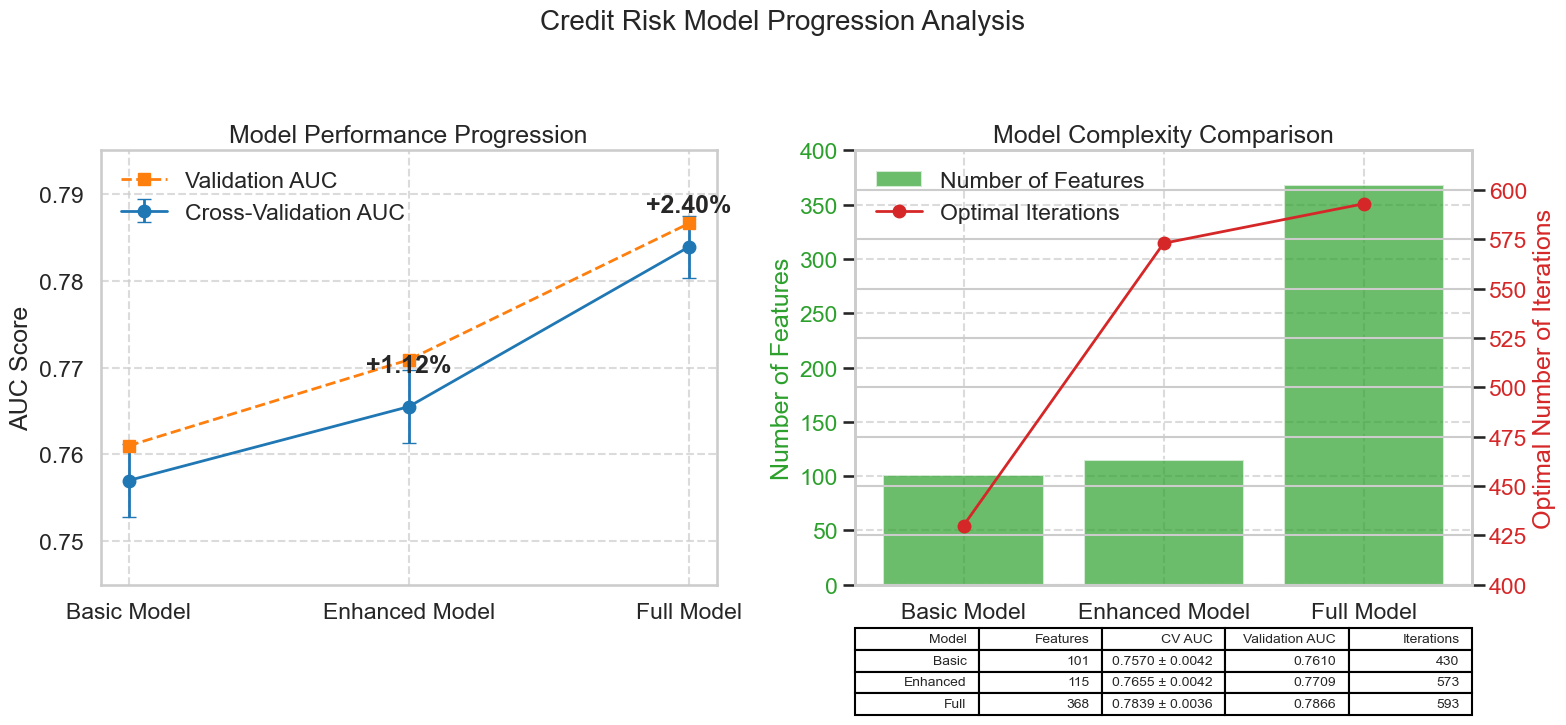

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Set the style for the plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk")

# Model data
models = ['Basic Model', 'Enhanced Model', 'Full Model']
features = [101, 115, 368]
cv_auc = [0.7570, 0.7655, 0.7839]
cv_std = [0.0042, 0.0042, 0.0036]
iterations = [430, 573, 593]
validation_auc = [0.7610, 0.7709, 0.7866]

# Create a dataframe for easy plotting
model_df = pd.DataFrame({
    'Model': models,
    'Features': features,
    'CV_AUC': cv_auc,
    'CV_STD': cv_std,
    'Iterations': iterations,
    'Validation_AUC': validation_auc
})

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Plot 1: AUC scores
ax1.errorbar(models, cv_auc, yerr=cv_std, fmt='o-', linewidth=2, capsize=5, 
             color='#1f77b4', label='Cross-Validation AUC')
ax1.plot(models, validation_auc, 's--', linewidth=2, color='#ff7f0e', 
         label='Validation AUC')

# Add labels and title
ax1.set_ylabel('AUC Score')
ax1.set_title('Model Performance Progression')
ax1.set_ylim(0.745, 0.795)  # Set y-axis limits for better visualization
ax1.grid(True, linestyle='--', alpha=0.7)
ax1.legend()

# Plot 2: Features and Iterations
color = '#2ca02c'
ax2.bar(models, features, alpha=0.7, color=color, label='Number of Features')
ax2.set_ylabel('Number of Features', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, 400)

# Create a secondary y-axis for iterations
ax3 = ax2.twinx()
ax3.plot(models, iterations, 'o-', color='#d62728', linewidth=2, label='Optimal Iterations')
ax3.set_ylabel('Optimal Number of Iterations', color='#d62728')
ax3.tick_params(axis='y', labelcolor='#d62728')
ax3.set_ylim(400, 620)

# Add a title and grid
ax2.set_title('Model Complexity Comparison')
ax2.grid(True, linestyle='--', alpha=0.7)

# Add legends
lines1, labels1 = ax2.get_legend_handles_labels()
lines2, labels2 = ax3.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

# Annotate improvement percentages for AUC
for i in range(1, len(models)):
    improvement = (cv_auc[i] - cv_auc[i-1]) / cv_auc[i-1] * 100
    ax1.annotate(f'+{improvement:.2f}%', 
                xy=(i, cv_auc[i]),
                xytext=(i, cv_auc[i] + 0.004),
                ha='center',
                fontweight='bold')

# Add a table with the model details
table_data = [
    ['Model', 'Features', 'CV AUC', 'Validation AUC', 'Iterations'],
    ['Basic', features[0], f'{cv_auc[0]:.4f} ± {cv_std[0]:.4f}', f'{validation_auc[0]:.4f}', iterations[0]],
    ['Enhanced', features[1], f'{cv_auc[1]:.4f} ± {cv_std[1]:.4f}', f'{validation_auc[1]:.4f}', iterations[1]],
    ['Full', features[2], f'{cv_auc[2]:.4f} ± {cv_std[2]:.4f}', f'{validation_auc[2]:.4f}', iterations[2]]
]

table = plt.table(cellText=table_data, loc='bottom', bbox=[0.0, -0.3, 1.0, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

# Adjust layout to make room for the table
plt.subplots_adjust(bottom=0.25)

plt.suptitle('Credit Risk Model Progression Analysis', fontsize=20, y=1.05)
plt.tight_layout()

# Save the figure
plt.savefig('model_progression.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()